### Name: Ami Gandhi
### Email: gandhi.am@husky.neu.edu

### Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns
import pylab
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind,probplot,mannwhitneyu,levene
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report

In [2]:
# Defining required functions

def readCsv(workdir, filePath):
    """
    Description: Function to read csv files.
    Input: Filepath
    Output: Dataframe with csv data
    """
    raw_data_path = os.path.join(workdir, filePath)
    data = pd.read_csv(raw_data_path)
    return data

def getWeekNumber(dataframe): 
    """
    Description: Function to get week number from date.
    Input: dataframe with date column
    Output: Dataframe with week number column
    """
    dataframe['Week_Number'] = dataframe['date'].dt.week
    return dataframe

def meanOrderValue(dataframe, gender):
    """
    Description: Function to get mean value of column.
    Input: data and gender(0 or 1)
    Output: value of mean
    """
    return dataframe[dataframe['gender']==gender].value.mean()

In [3]:
workdir = os.getcwd()
data = readCsv(workdir, 'screening_exercise_orders_v201810.csv')

In [4]:
# understanding data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
customer_id         13471 non-null int64
gender              13471 non-null int64
date                13471 non-null object
value               13471 non-null float64
predicted_gender    13471 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 526.3+ KB


In [5]:
# Transforming date column to datetime
data['date'] = pd.to_datetime(data['date'], format= "%Y-%m-%d %H:%M:%S")

### Data analysis and arranging data in following format:
1. Customer_id
2. gender
3. Most_recent_order_date
4. order_count (number of orders placed by this customer)

Sorting the dataframe by customer_id in ascending order and displaying the first 10 records.

In [6]:
dataInFormat = data.groupby('customer_id') \
                .agg({'gender':np.max,'date': np.max,'value': np.size}) \
                .rename(columns={'date':'most_recent_order_date','value':'order_count'}) \
                .reset_index()
dataInFormat.head(10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1.0
1,1001,0,2017-01-01 00:29:56,1.0
2,1002,1,2017-02-19 21:35:31,3.0
3,1003,1,2017-04-26 02:37:20,4.0
4,1004,0,2017-01-01 03:11:54,1.0
5,1005,1,2017-12-16 01:39:27,2.0
6,1006,1,2017-05-09 15:27:20,3.0
7,1007,0,2017-01-01 15:59:50,1.0
8,1008,0,2017-12-17 05:47:48,3.0
9,1009,1,2017-01-01 19:27:17,1.0


### Counting of number of orders per week

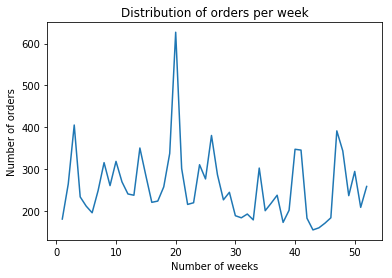

In [8]:
dataWithWeekNumber = getWeekNumber(data)
dataToPlot = dataWithWeekNumber.groupby('Week_Number').agg({'value': np.size}).reset_index()
dataToPlot.head()
plt.plot(dataToPlot['Week_Number'] , dataToPlot['value'])
plt.title('Distribution of orders per week')
plt.xlabel('Number of weeks')
plt.ylabel('Number of orders')
plt.show()

**OBSERVATION:**

The above plot is week number Vs order count for the year 2017. 
1. Week 20 was the most successful week in terms for order count
2. The lowest order count was in week 43 which is in the month of October and increases in the week of 47 which is the Black Friday week of the month.

#### Computing the mean order value for gender 0 and gender 1. Statistical inference on whether it is significant or not.

Assuming significance level 5% throughout to interpret the test results 

In [9]:
print('Mean of gender 0 is: {0}'.format(meanOrderValue(data,0)))
print('Mean of gender 1 is: {0}'.format(meanOrderValue(data,1)))

Mean of gender 0 is: 363.89000591803506
Mean of gender 1 is: 350.70836114422


In [10]:
gender_0 = data[data["gender"]==0].value.values
gender_1 = data[data["gender"]==1].value.values
print('Total number of rows for gender 0 is {0}'.format(len(gender_0)))
print('Total number of rows for gender 1 is {0}'.format(len(gender_1)))
print('Variance of gender 0 is {0}'.format(np.var(gender_0)))
print('Variance of gender 1 is {0}'.format(np.var(gender_1)))

Total number of rows for gender 0 is 6759
Total number of rows for gender 1 is 6712
Variance of gender 0 is 157215.32713916257
Variance of gender 1 is 142488.59472913775


Now let's look at the data distribution for both the genders.

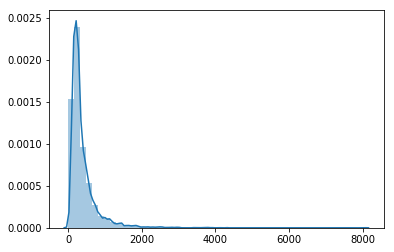

In [11]:
sns.distplot(gender_0)
# As observed data is right skewed and not normally distributed

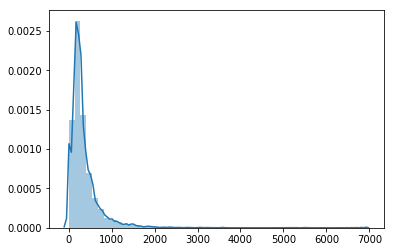

In [12]:
sns.distplot(gender_1)
# As observed data is right skewed and not normally distributed

**OBSERVATION:**

The above plots show that data is skewed towards the right. This is due to the fact that there are outliers in the data. Let us perform some analysis for the same.

### Outlier analysis

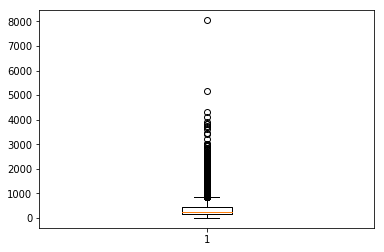

In [13]:
b0 = plt.boxplot(gender_0)

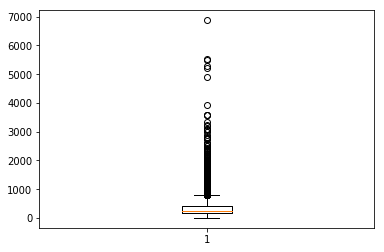

In [14]:
b1 = plt.boxplot(gender_1)

**OBSERVATION:**

Certain outliers are causing data distribution to be right skewed in both the cases as seen in above plots, hence let us remove the outliers and look at the distribution again.

In [15]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [16]:
lowerbound_g0,upperbound_g0 = outlier_treatment(data[data["gender"]==0].value)
lowerbound_g1,upperbound_g1 = outlier_treatment(data[data["gender"]==1].value)

In [17]:
# removing outliers
gender_0 = list(filter(lambda x: x!=0 and x<upperbound_g0,gender_0))
gender_1 = list(filter(lambda x: x!=0 and x<upperbound_g1,gender_1))

### Graphs after removing outliers

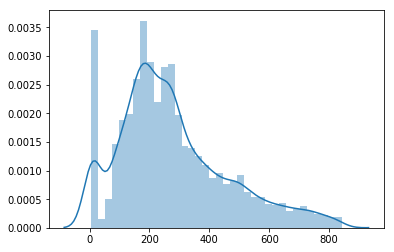

In [18]:
sns.distplot(gender_0)

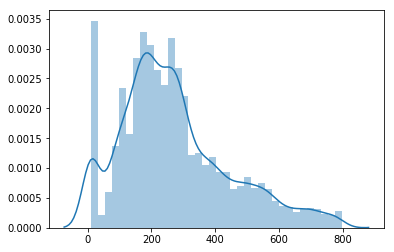

In [19]:
sns.distplot(gender_1)

**OBSERVATION:**

By observing above graphs after removing outliers, it looks like data is some what normally distributed but still not 100% normal. There are a lot of similar values because of which data still remains skewed. Hence, let us test if data is well normally distributed.

### Normality test using QQ-plot

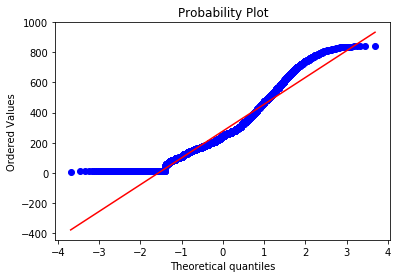

In [20]:
probplot(gender_0,plot=pylab)
pylab.show()

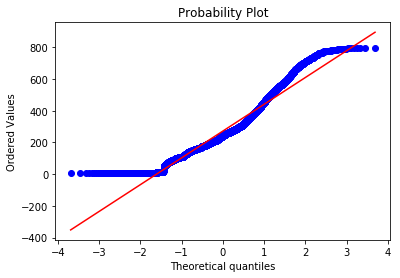

In [21]:
probplot(gender_1,plot=pylab)
pylab.show()

**Observation:**

Above observation proves that data is not normally distributed. We can apply transformations to make the distribution normal, lets transform to data to check if it will be useful or not.

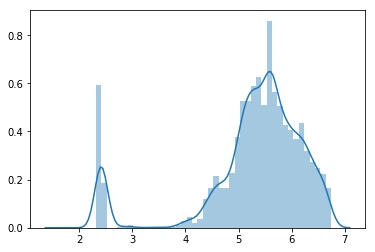

In [22]:
# adding 1 and applying log transformation to the data
g0 = list(map(lambda x: x+1,gender_0))
sns.distplot(np.log(g0))

It seems current data can't be transformed to normal distribution by logarithmic transformation.

Hence, I am considering our initial data distribution which seems almost normal and applying welch's t-test and student's t-test

### Test to assess equality of variances 

In [23]:
# Testing non-normal distribution for equal variances.
levene(gender_0,gender_1)

LeveneResult(statistic=10.180687580047902, pvalue=0.001422734017564412)

By referencing the p-value we can conclude that it is lower than significance level which is highly significant and hence, we reject null hypothesis and both gender 0 and gender 1 samples have unequal variances.

## Student's t-test

In [24]:
# Assumption: assuming gender_0 and gender_1 dataframe data distribution is normal.

t,p = ttest_ind(gender_0,gender_1,equal_var=True)
print('Value of t-statistic is: {0} and p-value is {1}'.format(t,p))

Value of t-statistic is: 1.885553384674115 and p-value is 0.05937856157167117


## Welch's t-test

In [25]:
t,p = ttest_ind(gender_0,gender_1,equal_var=False)
print('Value of t-statistic is: {0} and p-value is {1}'.format(t,p))

Value of t-statistic is: 1.8858076828170696 and p-value is 0.05934432126631661


Observed p-value is 0.05937 and 0.5934 slightly higher than significance level 0.05 (5%), meaning it is not significant enough to reject the null hypothesis and conclude that there is not much significant difference between the two means of two groups.

## Mann-Whitney U test 

In [26]:
u,p = mannwhitneyu(gender_0,gender_1,alternative='two-sided')
print('p-value is {0}'.format(p))

p-value is 0.34990288916951917


Here, the p-value is much higher than significance level which means that we cannot reject null hypothesis and hence means are equal. This observation is inline with the observation from welch's t-test and student's t-test.

#### Assuming a single gender prediction was made for each customer, let us generate a confusion matrix for predicted gender and understand what does this confusion matrix tell about the quality of the predictions.

Finding the confusion matrix for the given columns i.e. gender and predicted_gender

In [27]:
cf = confusion_matrix(data['gender'],data['predicted_gender'])

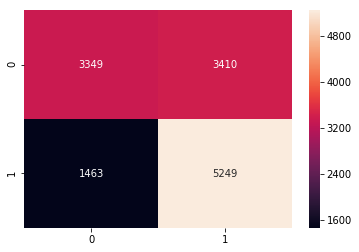

In [28]:
sns.heatmap(cf,annot=True,fmt="d")

In [29]:
print(classification_report(data['gender'],data['predicted_gender']))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58      6759
           1       0.61      0.78      0.68      6712

   micro avg       0.64      0.64      0.64     13471
   macro avg       0.65      0.64      0.63     13471
weighted avg       0.65      0.64      0.63     13471



1. Precision is the ratio of tp/(tp+fp) where tp is number of true positives and fp is number of false positives. 
2. Recall is the ratio of tp/(tp+fn) where tp is number of true positives and fn is number of false negative.
3. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0

F1 = 2 * (precision * recall) / (precision + recall)

In [30]:
roc_auc_score(data['gender'],data['predicted_gender']) 

0.6387598396593356

Since it is a binary classification (predicted gender = 0 or 1), a random guess has 50% chance of getting a correct answer. Here, we get an AUC score of 0.63 and precision of 0.70 for gender 0 and 0.61 for gender 1 which isn't a very good score for binary classifier and hence we can conclude that model isn't a good classifier.

#### ------------------------------------------------------------------THANK YOU---------------------------------------------------------------------------------